In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# some lines have too many fields (?), so skip bad lines
imgatt = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CUB_200_2011/image_attribute_labels.txt",
                     sep='\s+', header=None, error_bad_lines=False, warn_bad_lines=False,
                     usecols=[0,1,2], names=['imgid', 'attid', 'present'])

# description from dataset README:
# 
# The set of attribute labels as perceived by MTurkers for each image
# is contained in the file attributes/image_attribute_labels.txt, with
# each line corresponding to one image/attribute/worker triplet:
#
# <image_id> <attribute_id> <is_present> <certainty_id> <time>
#
# where <image_id>, <attribute_id>, <certainty_id> correspond to the IDs
# in images.txt, attributes/attributes.txt, and attributes/certainties.txt
# respectively.  <is_present> is 0 or 1 (1 denotes that the attribute is
# present).  <time> denotes the time spent by the MTurker in seconds.


In [3]:
imgatt.head()

,imgid,attid,present
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,1


In [4]:
imgatt.shape

(3677856, 3)

In [5]:
# need to reorganize imgatt to have one row per imgid, and 312 columns (one column per attribute),
# with 1/0 in each cell representing if that imgid has that attribute or not

imgatt2 = imgatt.pivot(index='imgid', columns='attid', values='present')

In [6]:
imgatt2.head()

attid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
imgid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
5,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [7]:
imgatt2.shape

(11788, 312)

In [8]:
# now we need to load the image true classes

imglabels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CUB_200_2011/image_class_labels.txt", 
                        sep=' ', header=None, names=['imgid', 'label'])

imglabels = imglabels.set_index('imgid')

# description from dataset README:
#
# The ground truth class labels (bird species labels) for each image are contained
# in the file image_class_labels.txt, with each line corresponding to one image:
#
# <image_id> <class_id>
#
# where <image_id> and <class_id> correspond to the IDs in images.txt and classes.txt,
# respectively.

In [9]:
imglabels.head()

,label
imgid,
1,1
2,1
3,1
4,1
5,1


In [10]:
imglabels.shape

(11788, 1)

In [11]:
# now we need to attach the labels to the attribute data set,
# and shuffle; then we'll separate a test set from a training set

df = imgatt2.join(imglabels)
df = df.sample(frac=1)

In [12]:
df_att = df.iloc[:, :312]
df_label = df.iloc[:, 312:]

In [13]:
df_att.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
imgid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4182,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
9685,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4451,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
10753,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9707,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
df_label.head()

,label
imgid,
4182,72
9685,165
4451,77
10753,183
9707,165


In [15]:
df_train_att = df_att[:8000]
df_train_label = df_label[:8000]
df_test_att = df_att[8000:]
df_test_label = df_label[8000:]

df_train_label = df_train_label['label']
df_test_label = df_test_label['label']

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_features=50, random_state=0, n_estimators=100)

In [17]:
clf.fit(df_train_att, df_train_label)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [18]:
print(clf.predict(df_train_att.head()))

[ 72 165  77 183 165]


In [19]:
clf.score(df_test_att, df_test_label)

0.4448257655755016

In [20]:
from sklearn.metrics import confusion_matrix
pred_labels = clf.predict(df_test_att)
cm = confusion_matrix(df_test_label, pred_labels)

In [21]:
cm

array([[ 3,  2,  1, ...,  0,  0,  0],
       [ 1, 14,  0, ...,  0,  0,  0],
       [ 1,  1,  4, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  4,  0,  0],
       [ 1,  0,  0, ...,  1,  7,  0],
       [ 0,  0,  0, ...,  0,  0, 14]])

In [22]:
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, format(cm[i, j], fmt),
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
birds = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CUB_200_2011/classes.txt",
                    sep='\s+', header=None, usecols=[1], names=['birdname'])
birds = birds['birdname']
birds

0      001.Black_footed_Albatross
1            002.Laysan_Albatross
2             003.Sooty_Albatross
3           004.Groove_billed_Ani
4              005.Crested_Auklet
                  ...            
195                196.House_Wren
196                197.Marsh_Wren
197                 198.Rock_Wren
198               199.Winter_Wren
199       200.Common_Yellowthroat
Name: birdname, Length: 200, dtype: object

Normalized confusion matrix
[[0.2  0.13 0.07 ... 0.   0.   0.  ]
 [0.05 0.7  0.   ... 0.   0.   0.  ]
 [0.08 0.08 0.33 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.05 ... 0.18 0.   0.  ]
 [0.04 0.   0.   ... 0.04 0.29 0.  ]
 [0.   0.   0.   ... 0.   0.   0.67]]


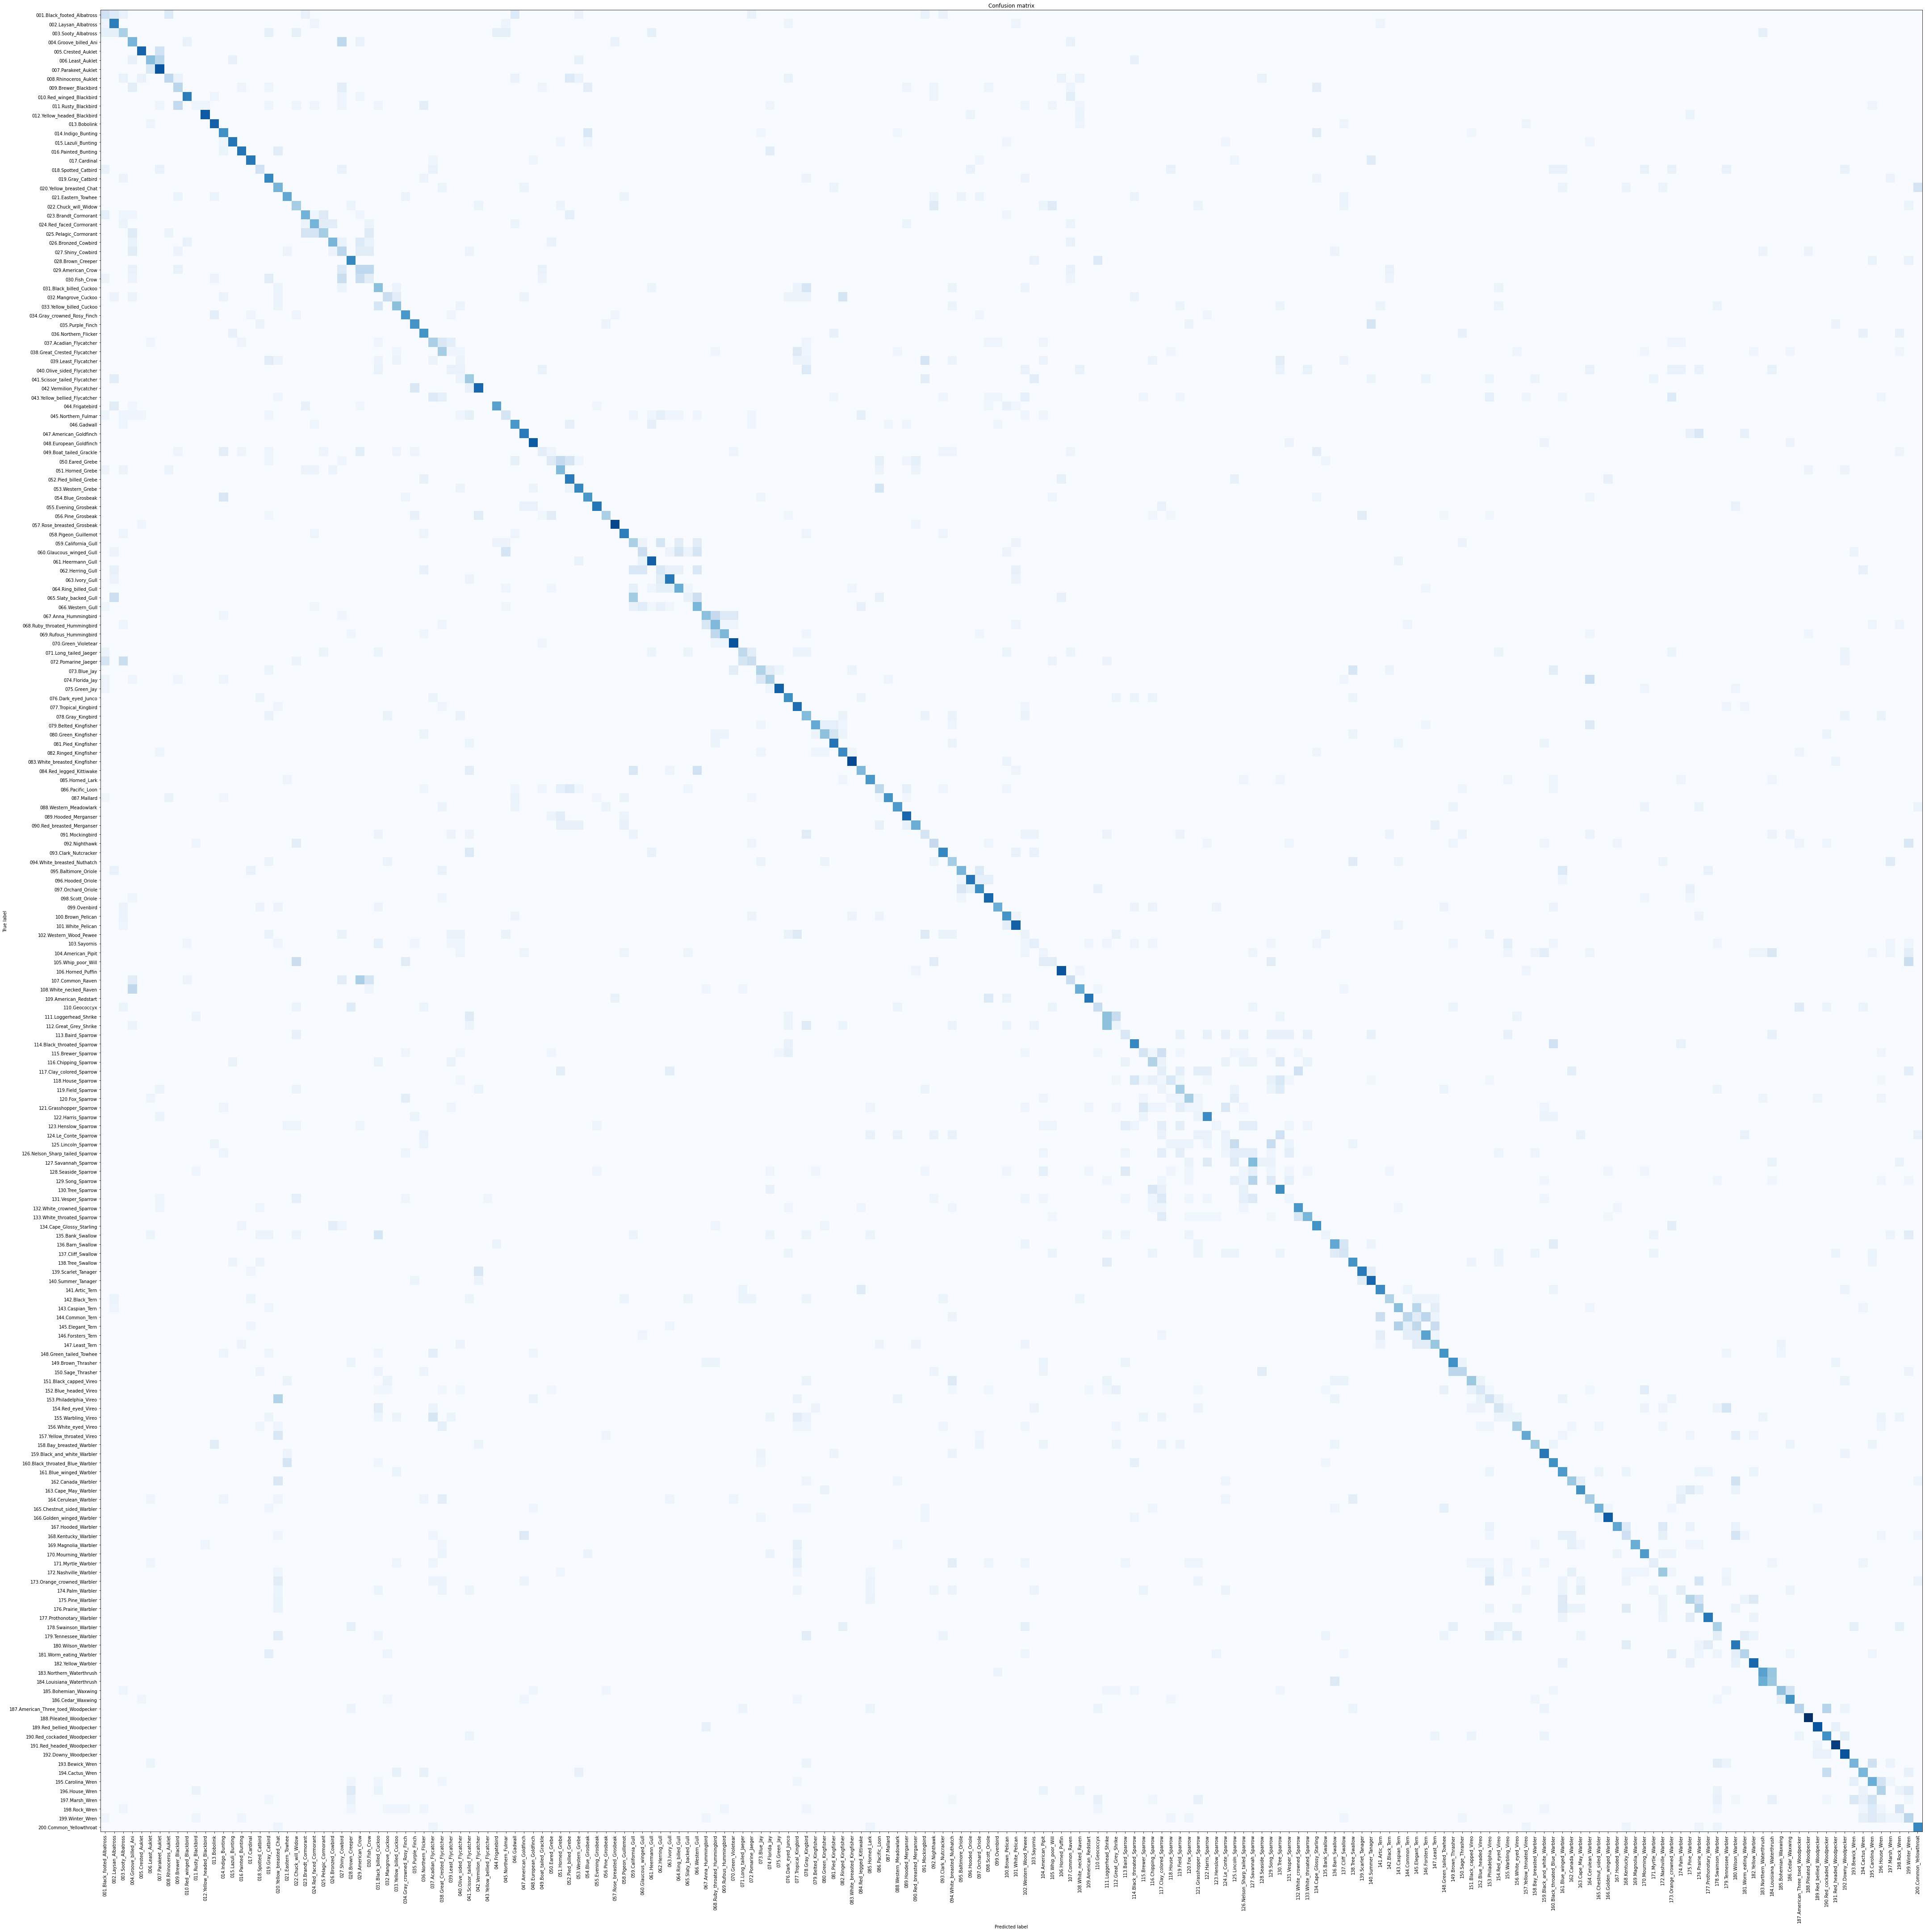

In [24]:
import numpy as np
np.set_printoptions(precision=2)
plt.figure(figsize=(60,60), dpi=72)
plot_confusion_matrix(cm, classes=birds, normalize=True)
plt.show()

In [25]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier()
clftree.fit(df_train_att, df_train_label)
clftree.score(df_test_att, df_test_label)

0.27639915522703273

In [26]:
from sklearn import svm
clfsvm = svm.SVC()
clfsvm.fit(df_train_att, df_train_label)
clfsvm.score(df_test_att, df_test_label)

0.46462513199577615

In [38]:
from sklearn import svm
clfsvm = svm.SVC(kernel='linear')
clfsvm.fit(df_train_att, df_train_label)
clfsvm.score(df_test_att, df_test_label)

0.4553854276663147

In [39]:
from sklearn import svm
clfsvm = svm.SVC(kernel='poly')
clfsvm.fit(df_train_att, df_train_label)
clfsvm.score(df_test_att, df_test_label)

0.46462513199577615

In [40]:
from sklearn import svm
clfsvm = svm.SVC(sigmoid)
clfsvm.fit(df_train_att, df_train_label)
clfsvm.score(df_test_att, df_test_label)

KeyboardInterrupt: ignored

In [ ]:
from sklearn import svm
clfsvm = svm.SVC(precomputed)
clfsvm.fit(df_train_att, df_train_label)
clfsvm.score(df_test_att, df_test_label)

#3.3 Yes, we can apply different kernels.
#‘rbf’ is the default kernel that is used here
#‘linear’ decreases the accuracy slighlty
#‘poly’ is same as 'rbf'

#3.4 Chagning C and gamma can lead to improving accuracy

In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, df_train_att, df_train_label, cv=5)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.44 (+/- 0.02)


In [31]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, df_train_att, df_train_label, cv=10)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.46 (+/- 0.02)


In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, df_train_att, df_train_label, cv=30)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 27 members, which is less than n_splits=30.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.47 (+/- 0.05)


In [37]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, df_train_att, df_train_label, cv=50)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 27 members, which is less than n_splits=50.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.47 (+/- 0.07)


#3.2 cv here means cross-validation and determines cross-validation splitting strategy
#If we increase cv it improves the yield accuracy

In [28]:
scorestree = cross_val_score(clftree, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorestree.mean(), scorestree.std() * 2))

Accuracy: 0.26 (+/- 0.01)


In [29]:
scoressvm = cross_val_score(clfsvm, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoressvm.mean(), scoressvm.std() * 2))

Accuracy: 0.47 (+/- 0.01)


In [30]:
max_features_opts = range(5, 50, 5)
n_estimators_opts = range(10, 200, 20)
rf_params = np.empty((len(max_features_opts)*len(n_estimators_opts),4), float)
i = 0
for max_features in max_features_opts:
    for n_estimators in n_estimators_opts:
        clf = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
        scores = cross_val_score(clf, df_train_att, df_train_label, cv=5)
        rf_params[i,0] = max_features
        rf_params[i,1] = n_estimators
        rf_params[i,2] = scores.mean()
        rf_params[i,3] = scores.std() * 2
        i += 1
        print("Max features: %d, num estimators: %d, accuracy: %0.2f (+/- %0.2f)" % \
              (max_features, n_estimators, scores.mean(), scores.std() * 2))

Max features: 5, num estimators: 10, accuracy: 0.27 (+/- 0.02)
Max features: 5, num estimators: 30, accuracy: 0.37 (+/- 0.02)
Max features: 5, num estimators: 50, accuracy: 0.39 (+/- 0.02)
Max features: 5, num estimators: 70, accuracy: 0.41 (+/- 0.01)
Max features: 5, num estimators: 90, accuracy: 0.42 (+/- 0.02)
Max features: 5, num estimators: 110, accuracy: 0.43 (+/- 0.02)
Max features: 5, num estimators: 130, accuracy: 0.44 (+/- 0.03)
Max features: 5, num estimators: 150, accuracy: 0.44 (+/- 0.02)
Max features: 5, num estimators: 170, accuracy: 0.44 (+/- 0.02)
Max features: 5, num estimators: 190, accuracy: 0.44 (+/- 0.01)
Max features: 10, num estimators: 10, accuracy: 0.29 (+/- 0.01)
Max features: 10, num estimators: 30, accuracy: 0.38 (+/- 0.02)
Max features: 10, num estimators: 50, accuracy: 0.41 (+/- 0.02)
Max features: 10, num estimators: 70, accuracy: 0.43 (+/- 0.02)
Max features: 10, num estimators: 90, accuracy: 0.44 (+/- 0.02)
Max features: 10, num estimators: 110, accura

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
fig.clf()
ax = fig.gca(projection='3d')
x = rf_params[:,0]
y = rf_params[:,1]
z = rf_params[:,2]
ax.scatter(x, y, z)
ax.set_zlim(0.2, 0.5)
ax.set_xlabel('Max features')
ax.set_ylabel('Num estimators')
ax.set_zlabel('Avg accuracy')
plt.show()